<a href="https://colab.research.google.com/github/Aadhiveerasankar/library-management/blob/main/Final_code_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading & Preprocessing

In [ ]:
import os
from PIL import Image
import numpy as np
def load_images_with_labels_and_paths(base_path):
    data = []
    labels = []
    paths = []
    counts = {}

    categories = ['Original']
    session_folders = [f'S{num:03d}' for num in range(1, 68)]
    conditions = ['Algometer Pain', 'Laser Pain', 'Neutral', 'Posed Pain']

    # Initial structure for counts
    for category in categories:
        counts[category] = {}
        for session in session_folders:
            counts[category][session] = {cond: 0 for cond in conditions}

    # Load images
    for category in categories:
        category_path = os.path.join(base_path, category)
        for session_folder in session_folders:
            session_path = os.path.join(category_path, session_folder)
            for condition in conditions:
                condition_path = os.path.join(session_path, condition)
                if os.path.isdir(condition_path):
                    for filename in os.listdir(condition_path):
                        if condition == "Poised Pain":
                            # Specific check for "Poised Pain" to include any jpg or png files
                            if "S001F" in filename and filename.endswith((".jpg", ".png")):
                                file_path = os.path.join(condition_path, filename)
                                process_image(file_path, condition, data, labels, paths, category, session_folder, counts)
                        else:
                            # General condition matching for other conditions
                            if filename.endswith((".jpg", ".png")):
                                file_path = os.path.join(condition_path, filename)
                                process_image(file_path, condition, data, labels, paths, category, session_folder, counts)
                else:
                    print(f"Directory not found: {condition_path}")

    return np.array(data), labels, paths, counts

def process_image(file_path, condition, data, labels, paths, category, session_folder, counts):
    with Image.open(file_path) as img:
        img = img.resize((128, 128))
        img_array = np.array(img) / 255.0
        data.append(img_array)
        labels.append(f"{session_folder}-{condition}")
        paths.append(file_path)
        counts[category][session_folder][condition] += 1

# Set the correct base path for your dataset
base_path = "C:/Users/Downloads/pain/Pictures"
data, labels, paths, counts = load_images_with_labels_and_paths(base_path)

# Printing the counts in a structured way
for category, sessions in counts.items():
    print(f"Category: {category}")
    for session, condition_counts in sessions.items():
        print(f"  Session: {session}")
        for condition, count in condition_counts.items():
            print(f"    Condition: {condition} -> Count: {count}")




Directory not found: C:/Users/Geetha/Downloads/pain/Pictures\Original\S006\Posed Pain
Category: Original
  Session: S001
    Condition: Algometer Pain -> Count: 20
    Condition: Laser Pain -> Count: 20
    Condition: Neutral -> Count: 20
    Condition: Posed Pain -> Count: 20
  Session: S002
    Condition: Algometer Pain -> Count: 20
    Condition: Laser Pain -> Count: 20
    Condition: Neutral -> Count: 20
    Condition: Posed Pain -> Count: 20
  Session: S003
    Condition: Algometer Pain -> Count: 20
    Condition: Laser Pain -> Count: 20
    Condition: Neutral -> Count: 20
    Condition: Posed Pain -> Count: 20
  Session: S004
    Condition: Algometer Pain -> Count: 20
    Condition: Laser Pain -> Count: 20
    Condition: Neutral -> Count: 20
    Condition: Posed Pain -> Count: 20
  Session: S005
    Condition: Algometer Pain -> Count: 20
    Condition: Laser Pain -> Count: 20
    Condition: Neutral -> Count: 20
    Condition: Posed Pain -> Count: 20
  Session: S006
    Condition:

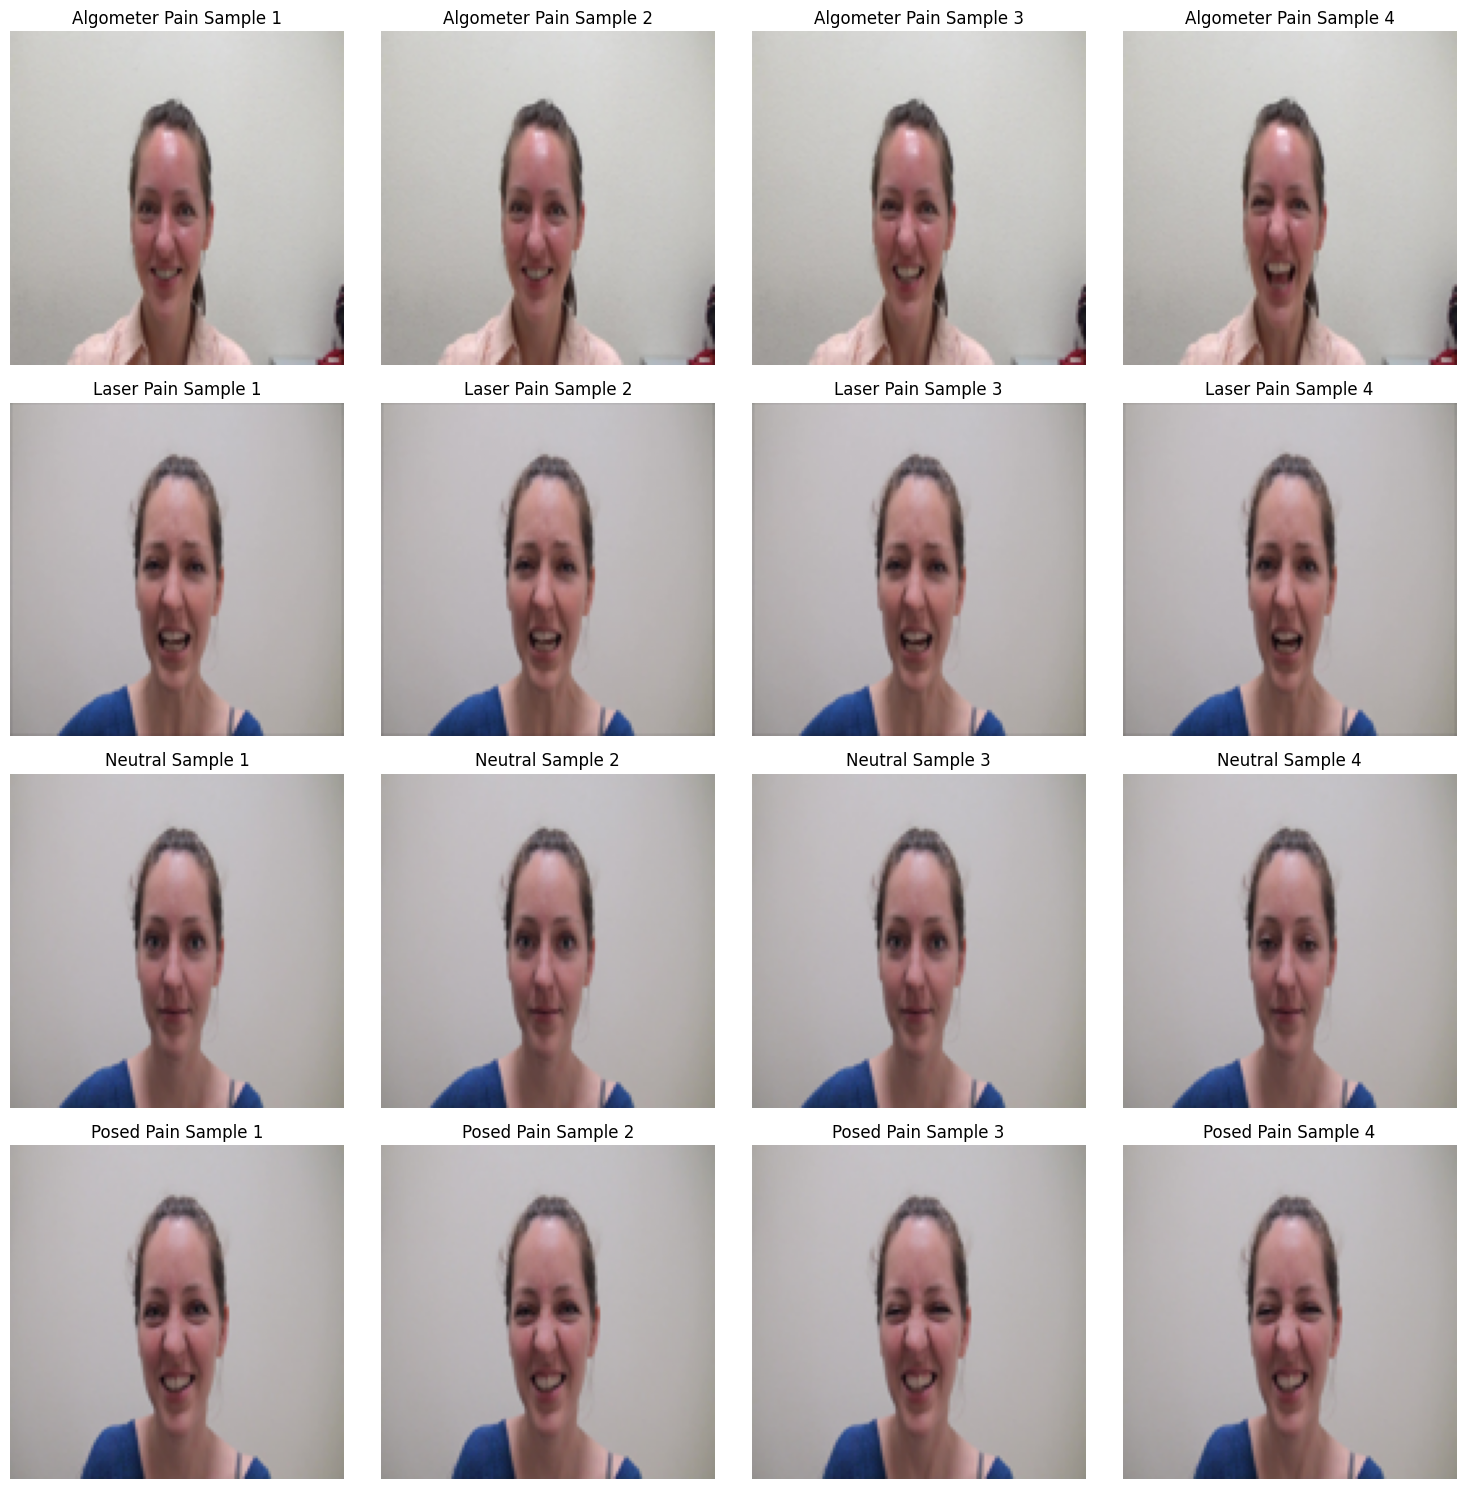

In [ ]:
import matplotlib.pyplot as plt

def plot_samples(data, labels, num_samples=4):
    conditions = ['Algometer Pain', 'Laser Pain', 'Neutral', 'Posed Pain']
    condition_samples = {cond: [] for cond in conditions}

    # Gather first available samples for each condition
    for img, label in zip(data, labels):
        for condition in conditions:
            if condition in label and len(condition_samples[condition]) < num_samples:
                condition_samples[condition].append(img)
                break

    # Create subplots: One row per condition, num_samples columns
    fig, axs = plt.subplots(len(conditions), num_samples, figsize=(15, 15))

    # Plot samples for each condition
    for idx, condition in enumerate(conditions):
        if len(condition_samples[condition]) > 0:
            for sample_idx in range(num_samples):
                if len(condition_samples[condition]) > sample_idx:  # Check for available samples
                    axs[idx, sample_idx].imshow(condition_samples[condition][sample_idx])
                    axs[idx, sample_idx].set_title(f'{condition} Sample {sample_idx+1}')
                    axs[idx, sample_idx].axis('off')
                else:
                    axs[idx, sample_idx].set_visible(False)  # Hide axes if no samples available
        else:
            for sample_idx in range(num_samples):
                axs[idx, sample_idx].set_visible(False)  # Hide entire row if no samples

    plt.tight_layout()
    plt.show()

# Call the function to plot the samples
plot_samples(data, labels)


# Encoding Data & Performing Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import joblib
# Load and label images , # Encode labels, # Save the Label Encoder , # Split the data [X_train, X_test, y_train, y_test | X_train, X_val, y_train, y_val]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Save the Label Encoder
joblib.dump(label_encoder, 'label_encoder.joblib')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, categorical_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Printing dataset shapes to confirm correct splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (3264, 128, 128, 3), (3264, 267)
Validation set: (1088, 128, 128, 3), (1088, 267)
Test set: (1088, 128, 128, 3), (1088, 267)


# Create the Check point to save the best model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')

# VGG16 Modelling

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load the base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Create new model on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 5.2995 - accuracy: 0.0466
Epoch 1: val_loss improved from inf to 4.70098, saving model to best_model.h5
102/102 [==============================] - 82s 795ms/step - loss: 5.2995 - accuracy: 0.0466 - val_loss: 4.7010 - val_accuracy: 0.2426
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 4.2228 - accuracy: 0.2120
Epoch 2: val_loss improved from 4.70098 to 3.59021, saving model to best_model.h5
102/102 [==============================] - 80s 788ms/step - loss: 4.2228 - accuracy: 0.2120 - val_loss: 3.5902 - val_accuracy: 0.3695
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 3.2409 - accuracy: 0.3453
Epoch 3: val_loss improved from 3.59021 to 2.59722, saving model to best_model.h5
102/102 [==============================] - 81s 793ms/step - loss: 3.2409 - accuracy: 0.3453 - val_loss: 2.5972 - val_accuracy: 0.4761
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

34/34 [==============================] - 20s 596ms/step - loss: 0.2652 - accuracy: 0.9577
Test Accuracy: 0.9577205777168274


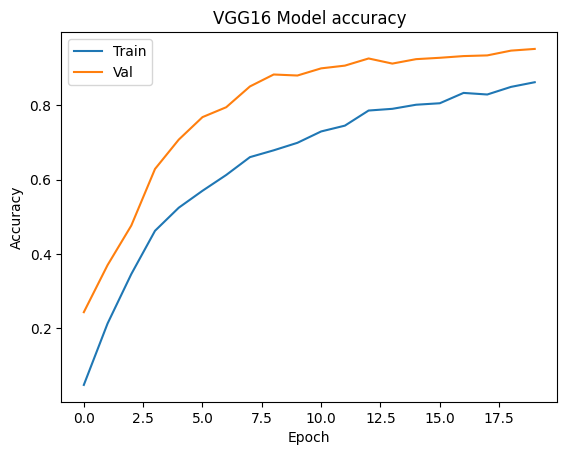

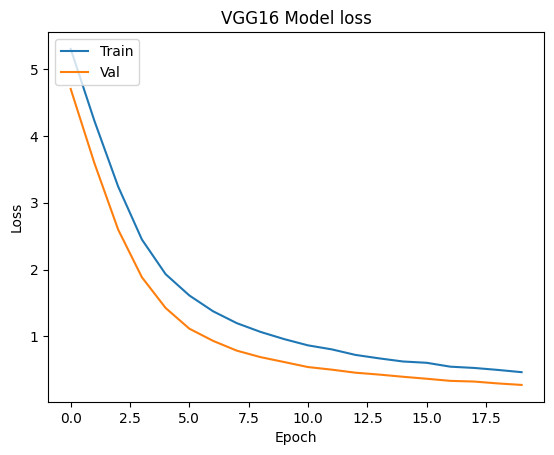

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

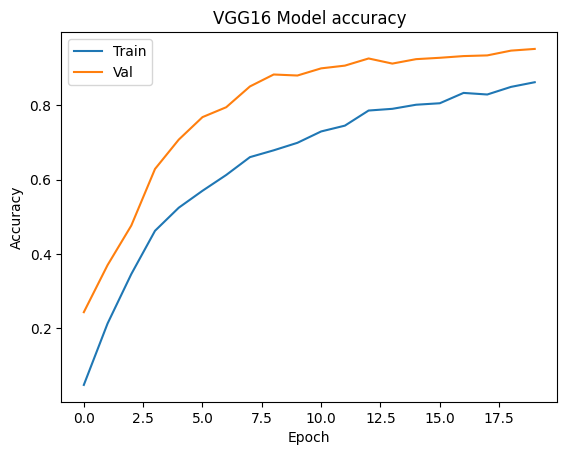

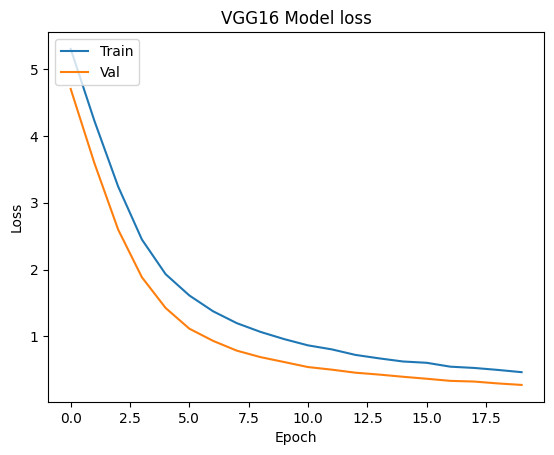

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# CNN Modelling

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu

# Define the custom CNN model with improved architecture
def create_custom_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Activation(relu),
        Conv2D(32, (3, 3), padding='same'),
        BatchNormalization(),
        Activation(relu),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),


        Flatten(),
        Dense(512),
        BatchNormalization(),
        Activation(relu),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile the CNN model
cnn_model = create_custom_cnn((128, 128, 3), len(label_encoder.classes_))
optimizer = Adam(lr=0.001)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_101 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 activation_101 (Activation)  (None, 128, 128, 32)     0         
                                                                 
 conv2d_105 (Conv2D)         (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_102 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 activation_102 (Activation)  (None, 128, 128, 32)    

In [ ]:
# Train the model
cnn_history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

# Evaluate the model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test)
print("CNN Test Accuracy:", cnn_test_acc)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 1.7852 - accuracy: 0.6627
Epoch 1: val_loss did not improve from 0.05783
102/102 [==============================] - 83s 808ms/step - loss: 1.7852 - accuracy: 0.6627 - val_loss: 7.6553 - val_accuracy: 0.0074
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9461
Epoch 2: val_loss did not improve from 0.05783
102/102 [==============================] - 87s 853ms/step - loss: 0.2022 - accuracy: 0.9461 - val_loss: 7.3309 - val_accuracy: 0.0119
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.1223 - accuracy: 0.9638
Epoch 3: val_loss did not improve from 0.05783
102/102 [==============================] - 87s 853ms/step - loss: 0.1223 - accuracy: 0.9638 - val_loss: 5.8327 - val_accuracy: 0.0561
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9755
Epoch 4: val_loss did not improve from 0.05783
102/102 [=================

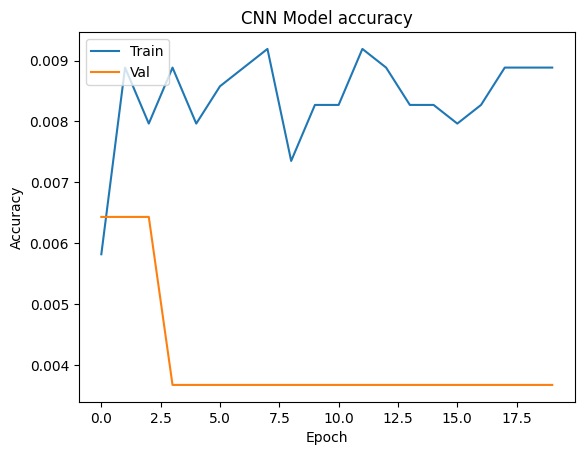

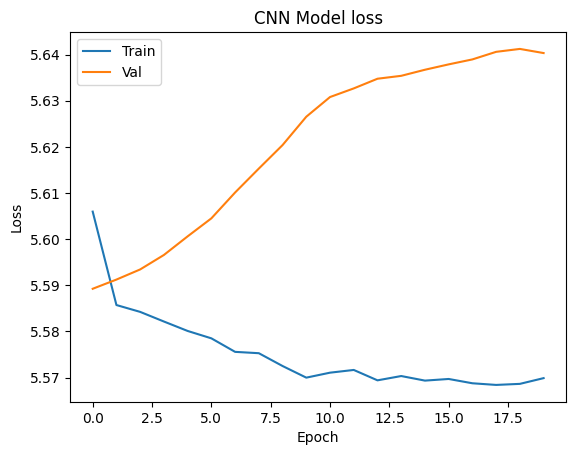

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Inception Modelling

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load the base Inception model
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
inception_model.trainable = False
# Create new model on top
x = inception_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(512, activation='relu')(x)  # Add a fully-connected layer
x = Dropout(0.5)(x)  # Add a dropout layer to prevent overfitting
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Create final prediction layer

model_inception = Model(inputs=inception_model.input, outputs=predictions)
# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_inception.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d_4[0][0]']               
 alization)                                                                                       
                                                                                            

 batch_normalization_10 (BatchN  (None, 13, 13, 96)  288         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 13, 13, 32)  96          ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 13, 13, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 13, 13, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_24 (Conv2D)             (None, 13, 13, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_27 (Conv2D)             (None, 13, 13, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 13, 13, 48)  144         ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 13, 13, 96)  288         ['conv2d_27[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_38 (Conv2D)             (None, 6, 6, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 6, 6, 128)   384         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 6, 6, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 6, 6, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 6, 6, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 6, 6, 160)   480         ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_45

 batch_normalization_55 (BatchN  (None, 6, 6, 160)   480         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 6, 6, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 6, 6, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 6, 6, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 6, 6, 160)   480         ['conv2d_55[0][0]']              
 ormalizat

 conv2d_65 (Conv2D)             (None, 6, 6, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_70 (Conv2D)             (None, 6, 6, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 6, 6, 192)   576         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 6, 6, 192)   576         ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 6, 6, 192)   576         ['conv2d_78[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 6, 6, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 2, 2, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 2, 2, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 2, 2, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 2, 2, 192)   576         ['conv2d_88[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 2, 2, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 2, 2, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 2, 2, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 2, 2, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [ ]:
# Note: Ensure your data is resized to 128x128 for InceptionV3
# Train the model
inception_history = model_inception.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

# Evaluate the model
inception_test_loss, inception_test_acc = model_inception.evaluate(X_test, y_test)
print("InceptionV3 Test Accuracy:", inception_test_acc)

Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 5.2675 - accuracy: 0.0625
Epoch 1: val_loss did not improve from 0.27457
102/102 [==============================] - 28s 247ms/step - loss: 5.2675 - accuracy: 0.0625 - val_loss: 4.2147 - val_accuracy: 0.3281
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 3.6057 - accuracy: 0.2904
Epoch 2: val_loss did not improve from 0.27457
102/102 [==============================] - 24s 239ms/step - loss: 3.6057 - accuracy: 0.2904 - val_loss: 2.4820 - val_accuracy: 0.6406
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 2.1835 - accuracy: 0.5659
Epoch 3: val_loss did not improve from 0.27457
102/102 [==============================] - 24s 241ms/step - loss: 2.1835 - accuracy: 0.5659 - val_loss: 1.3576 - val_accuracy: 0.8208
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 1.3615 - accuracy: 0.6994
Epoch 4: val_loss did not improve from 0.27457
102/102 [=================

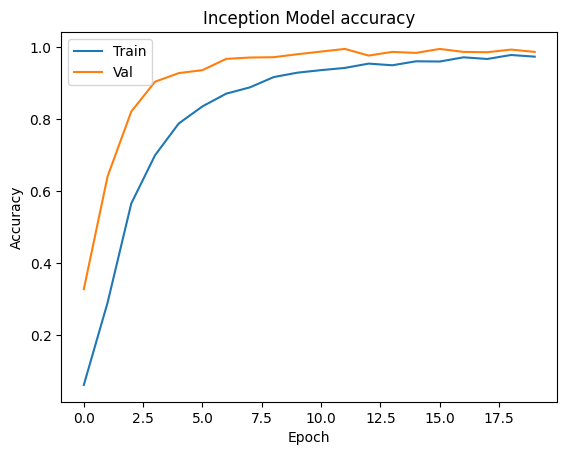

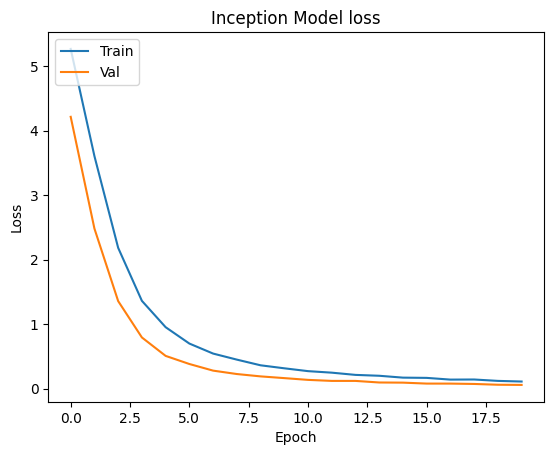

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('Inception Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('Inception Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Comparision of Three Models

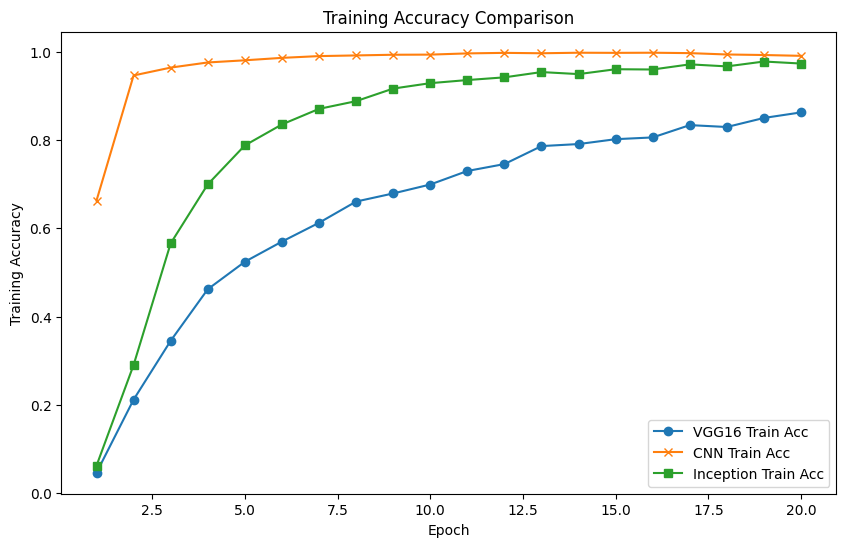

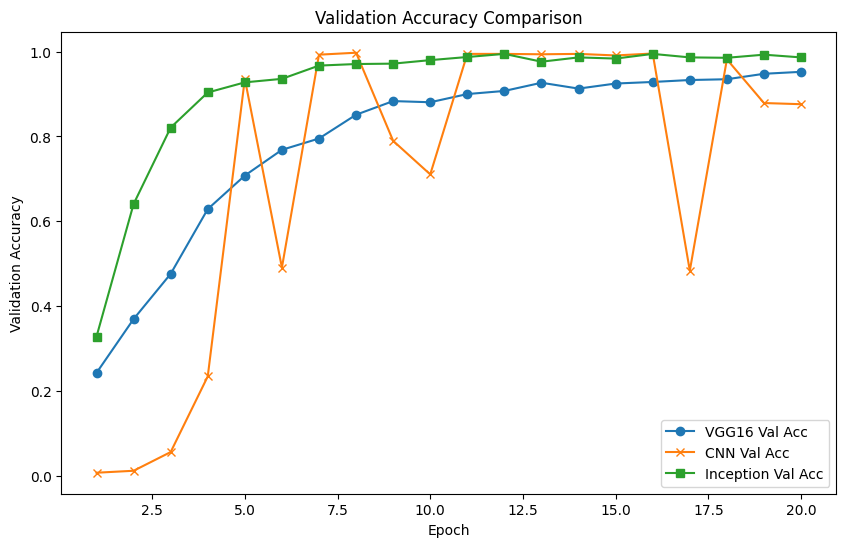

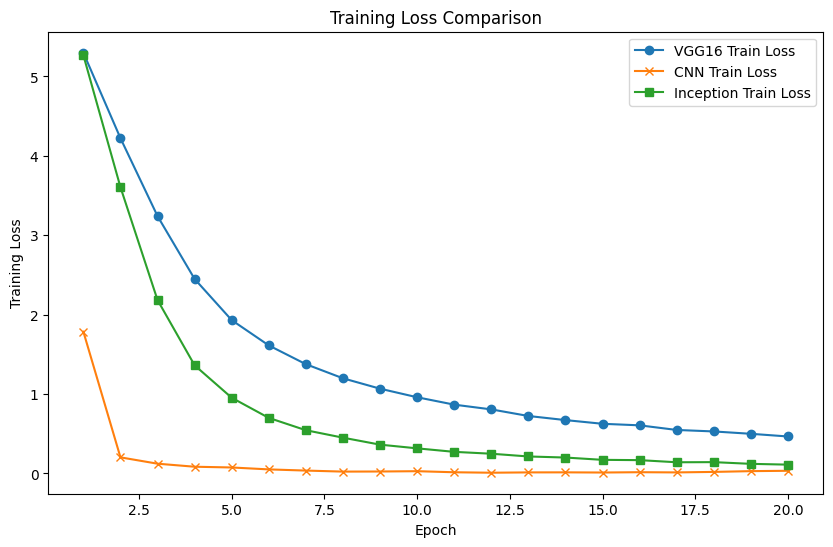

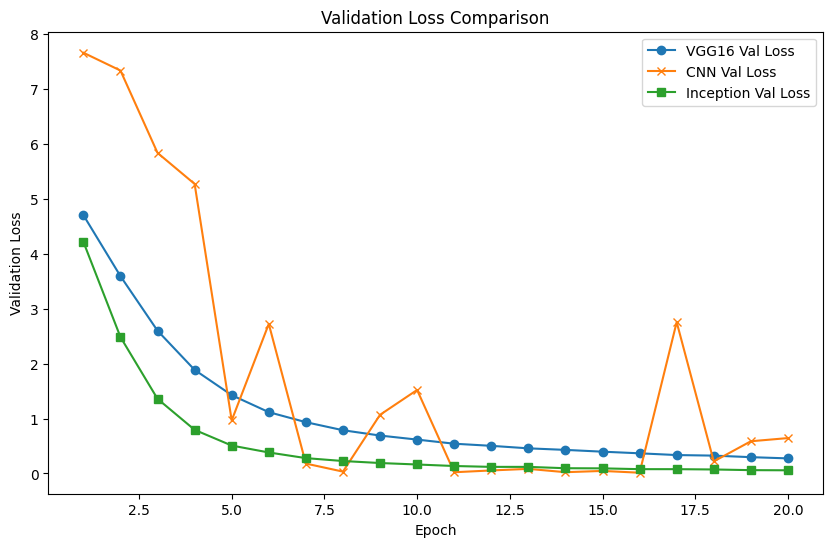

In [ ]:
import matplotlib.pyplot as plt

# Prepare the data for plotting
epochs = range(1, len(history.history['accuracy']) + 1)  # Assuming all models trained for the same number of epochs

# Training Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['accuracy'], 'o-', label='VGG16 Train Acc')  # Circle marker
plt.plot(epochs, cnn_history.history['accuracy'], 'x-', label='CNN Train Acc')  # Cross marker
plt.plot(epochs, inception_history.history['accuracy'], 's-', label='Inception Train Acc')  # Square marker
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

# Validation Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['val_accuracy'], 'o-', label='VGG16 Val Acc')  # Circle marker
plt.plot(epochs, cnn_history.history['val_accuracy'], 'x-', label='CNN Val Acc')  # Cross marker
plt.plot(epochs, inception_history.history['val_accuracy'], 's-', label='Inception Val Acc')  # Square marker
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# Training Loss Comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['loss'], 'o-', label='VGG16 Train Loss')  # Circle marker
plt.plot(epochs, cnn_history.history['loss'], 'x-', label='CNN Train Loss')  # Cross marker
plt.plot(epochs, inception_history.history['loss'], 's-', label='Inception Train Loss')  # Square marker
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Validation Loss Comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, history.history['val_loss'], 'o-', label='VGG16 Val Loss')  # Circle marker
plt.plot(epochs, cnn_history.history['val_loss'], 'x-', label='CNN Val Loss')  # Cross marker
plt.plot(epochs, inception_history.history['val_loss'], 's-', label='Inception Val Loss')  # Square marker
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


In [ ]:
print("InceptionV3 Test Accuracy:", inception_test_acc)
print("CNN Test Accuracy:", cnn_test_acc)
print("VGG16 Test Accuracy:", test_acc)

InceptionV3 Test Accuracy: 0.9926470518112183
CNN Test Accuracy: 0.8713235259056091
VGG16 Test Accuracy: 0.9577205777168274


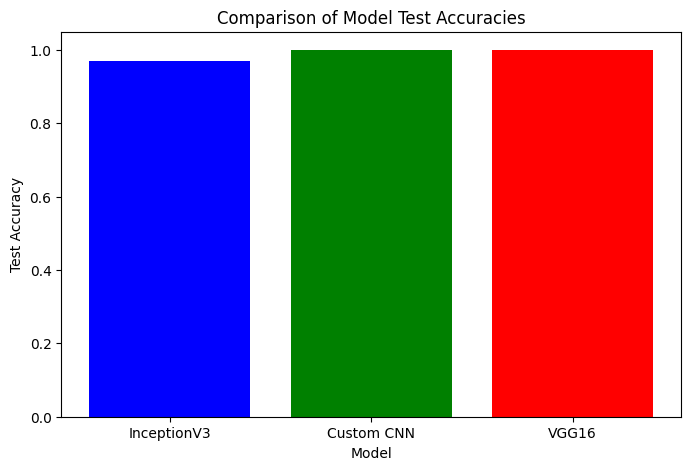

In [ ]:
import matplotlib.pyplot as plt

# Test accuracies for each model
inception_test_acc = 0.97  # Replace with your actual InceptionV3 accuracy
cnn_test_acc = 1.0        # Replace with your actual CNN accuracy
vgg_test_acc = 1.0        # Replace with your actual VGG16 accuracy

# Model names
models = ['InceptionV3', 'Custom CNN', 'VGG16']

# Corresponding accuracies
accuracies = [inception_test_acc, cnn_test_acc, vgg_test_acc]

# Create bar plot
plt.figure(figsize=(8, 5))  # Size of the plot
plt.bar(models, accuracies, color=['blue', 'green', 'red'])  # Bar colors
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Model Test Accuracies')
plt.show()


# Final Prediction Observations

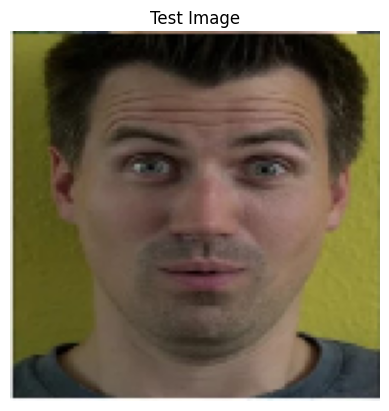

1/1 [==============================] - 1s 961ms/step
Predicted class: ['S022-Neutral']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import joblib
saved_model = load_model("best_model.h5")
label_encoder = joblib.load('label_encoder.joblib')
def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array /= 255.0  # Normalize to 0-1
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Example use
test_image = preprocess_image('C:/Users/Downloads/pain/2.jpg')
plt.imshow(np.squeeze(test_image))
plt.title("Test Image")
plt.axis('off')
plt.show()

predictions = saved_model.predict(test_image)
predicted_class_index = np.argmax(predictions, axis=1)
if predicted_class_index < len(label_encoder.classes_):
    predicted_class = label_encoder.classes_[predicted_class_index]
    print("Predicted class:", predicted_class)
else:
    print("Predicted class index out of range.")

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("best_model.h5")

# Print the model architecture
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_101 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 activation_101 (Activation)  (None, 128, 128, 32)     0         
                                                                 
 conv2d_105 (Conv2D)         (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_102 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 activation_102 (Activation)  (None, 128, 128, 32)    